**NER**

In [17]:
pip install neuralprophet

  Using cached dataclasses-0.6-py3-none-any.whl (14 kB)
Note: you may need to restart the kernel to use updated packages.


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import date, timedelta
from neuralprophet import NeuralProphet


import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

In [8]:
raot_cta_ner = pd.read_csv('ner_data.csv')
print(raot_cta_ner['ID'].nunique())
raot_cta_ner.head()

18523


,SURVEY_DATE,ID,NAME,STATE,CITY,MSA,SUBMARKET,CONSTRUCTION_TYPE,UNITS,NER
0,2017-09-18,57c701a1e650b70e00e31788,Villas at Shadow Creek Ranch,TX,Pearland,"Houston, TX",Brazoria County,Garden,560,1345.794642
1,2020-01-07,5ddc1efb669c31001d0288e3,Avail,CO,Aurora,"Denver, CO",Aurora-South,Garden,424,1727.790094
2,2020-10-04,5f6ba6deb8caa50003512f3d,Harmony 3900,UT,South Salt Lake,"Salt Lake City, UT",South Salt Lake/Cottonwood,Garden,285,1267.214035
3,2020-10-05,5cd3047060d93b001521eb6c,Lennox SouthPark Apartments,NC,Charlotte,"Charlotte, NC",Carmel,Mid-rise,239,1454.866108
4,2021-09-03,5e62b82b8c00b0001dd22b25,Portofino Landings,FL,Fort Pierce,"Port St. Lucie, FL",Other,Garden,236,1672.932203


In [9]:
raot_cta_ner['WEEK_START'] = pd.to_datetime(raot_cta_ner['SURVEY_DATE']).dt.date
raot_cta_ner = raot_cta_ner.sort_values(by='WEEK_START')

# select rows where date is between given start/end date (inclusive)
start_date = pd.to_datetime('1/1/2015')
end_date = pd.to_datetime('8/14/2022')

raot_cta_ner = raot_cta_ner.loc[
    (raot_cta_ner['WEEK_START'] >= start_date) & (raot_cta_ner['WEEK_START'] <= end_date)]

In [10]:
def start_week_date(survey_date):
    start_date = survey_date - timedelta(days=survey_date.weekday())
    
    return start_date

raot_cta_ner['WEEK_START'] = raot_cta_ner.apply(lambda x: start_week_date(x['WEEK_START']), axis=1)
raot_cta_ner.tail()

,SURVEY_DATE,ID,NAME,STATE,CITY,MSA,SUBMARKET,CONSTRUCTION_TYPE,UNITS,NER,WEEK_START
643506,2022-08-14,5aa146b5f32106001344bf1c,Artisan on 2nd Apartments,CA,Los Angeles,"Los Angeles, CA",Downtown,Mid-rise,118,3145.491525,2022-08-08
1140038,2022-08-14,5ddf17ed2adebb001d2c5f84,Signature Pointe Apartments,WA,Kent,"Seattle, WA",Des Moines/West Kent,Garden,628,2115.331210,2022-08-08
421512,2022-08-14,5642c17f55d27c0e003b6684,Stanford West,CA,Palo Alto,"San Jose, CA",Mountain View/Los Altos,Garden,628,3290.608280,2022-08-08
649983,2022-08-14,6202a2a8dbac13002a817c45,West Village,CA,San Jose,"San Jose, CA",Central San Jose,Garden,164,2111.195121,2022-08-08
800364,2022-08-14,5dfa6c65276c95001dc79cba,Talia Apartments,MA,Marlborough,"Boston, MA",West/Northwest Suburban,Mid-rise,225,2573.173333,2022-08-08


In [11]:
from prophet import Prophet
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [35]:
class prophet_model:
    def __init__(self, algorithm_name, prediction_period):
        self.algorithm_name = algorithm_name
        self.prediction_period = prediction_period
        self.model = Prophet()
        
    def transformation(self, data, time_col, target_col):
        data[time_col] = pd.to_datetime(data[time_col])
        data.rename(columns={time_col:'ds', target_col:'y'}, inplace=True)
        
        data.drop(data.columns.difference(['ds','y']), 1, inplace=True)

        train_data = data[:-self.prediction_period]
        test_data = data[-self.prediction_period:]
        
        return train_data, test_data
    
    def fit_model(self, train_data):
        
        self.model.fit(train_data)
        return self.model
        
    def predict(self):
        future_data = self.model.make_future_dataframe(periods=self.prediction_period, freq='w')
        forecast = self.model.predict(future_data)
        predictions = forecast[['ds', 'yhat']][-self.prediction_period:]
        return predictions
    
    def evaluation(self, test_data, predictions):
        mae = mean_absolute_error(predictions['yhat'], test_data['y'])
        #print("mean_absolute_error on testing set:", mae)
        
        mape = mean_absolute_percentage_error(predictions['yhat'], test_data['y'])
        #print("mean_absolute_percentage_error on testing set:", mape)

        r_squared = r2_score(predictions['yhat'], test_data['y'])
        #print("r2_score on testing set:", r_squared)
        
        return mape
    
    def plot(self, test_data, predictions, label):
        plt.figure(figsize=(10, 5))
        plt.plot(test_data['ds'], test_data['y'], label = 'real data')
        plt.plot(predictions['ds'], predictions['yhat'], label = 'predictions')
        plt.legend()
        plt.title(f'Forecast vs Actuals for {label} with an error of {round(self.evaluation(test_data, predictions),3)}%')
        plt.show()
        
        return None
    
    
    def save_model(self, filename):    
        pickle.dump(self.model, open(filename, 'wb'))

In [25]:
class NeuralProphetModel:
    def __init__(self, algorithm_name, prediction_period):
        self.algorithm_name = algorithm_name
        self.prediction_period = prediction_period
        self.model = NeuralProphet()
        
    def transformation(self, data, time_col, target_col):
        data[time_col] = pd.to_datetime(data[time_col])
        data.rename(columns={time_col:'ds', target_col:'y'}, inplace=True)
        
        data.drop(data.columns.difference(['ds','y']), 1, inplace=True)

        train_data = data[:-self.prediction_period]
        test_data = data[-self.prediction_period:]
        
        return train_data, test_data
            
    def fit_model(self, train_data):
        self.model.fit(train_data, freq="w")
        return self.model
        
    def predict(self, train_data):
        future_data = self.model.make_future_dataframe(train_data, periods=self.prediction_period, n_historic_predictions=0)
        forecast = self.model.predict(future_data)
        predictions = forecast[['ds', 'yhat1']]
        return predictions
    
    def evaluation(self, test_data, predictions):
        mae = mean_absolute_error(predictions['yhat1'], test_data['y'])
        print("mean_absolute_error on testing set:", mae)
        
        mape = mean_absolute_percentage_error(predictions['yhat1'], test_data['y'])
        print("mean_absolute_percentage_error on testing set:", mape)

        r_squared = r2_score(predictions['yhat1'], test_data['y'])
        print("r2_score on testing set:", r_squared)
        
        return mape
    
    def plot(self, test_data, predictions, label):
        plt.figure(figsize=(10, 5))
        plt.plot(test_data['ds'], test_data['y'], label = 'real data')
        plt.plot(predictions['ds'], predictions['yhat1'], label = 'predictions')
        plt.legend()
        plt.title(f'Forecast vs Actuals for {label} with an error of {round(self.evaluation(test_data, predictions),3)}%')
        plt.show()
        
        return None

    def save_model(self, filename):    
        pickle.dump(self.model, open(filename, 'wb'))

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.732% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 276


  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.41E-02, min: 1.82E-01


  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.41E-02, min: 1.82E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.19E-02
Epoch[276/276]: 100%|████████████| 276/276 [00:09<00:00, 29.59it/s, SmoothL1Loss=0.00267, MAE=32.8, RMSE=47, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.732% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 113.48660362035189
mean_absolute_percentage_error on testing set: 0.05316487069802776
r2_score on testing set: -2.353401112741294
mean_absolute_error on testing set: 113.48660362035189
mean_absolute_percentage_error on testing set: 0.05316487069802776
r2_score on testing set: -2.353401112741294


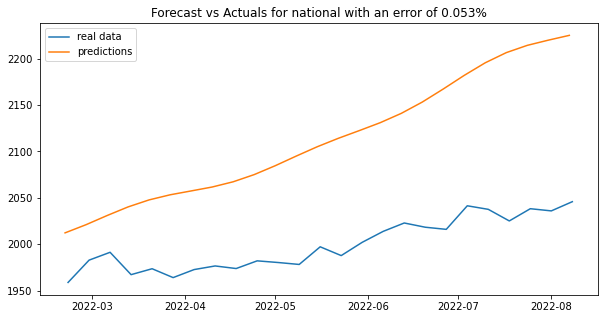

In [26]:
if __name__ == '__main__':
    avg_ner_data = raot_cta_ner.groupby(['WEEK_START']).agg({'UNITS':'sum','NER':'mean'}).reset_index()

    ## experimenting with a dataset
    prediction_period = 25
    algorithm_name = 'Prophet Model'
    
    results = NeuralProphetModel(algorithm_name, prediction_period)
    df_train, df_test = results.transformation(avg_ner_data, 'WEEK_START', 'NER')
    results.fit_model(df_train)
    predictions = results.predict(df_train)
    results.evaluation(df_test, predictions)
    results.plot(df_test, predictions, 'national')

# MSA Level

In [27]:
msa_data = pd.read_csv('msa_data.csv')
msa_data_lst = list(msa_data['MSA'])

subsets = dict((x, y) for x, y in raot_cta_ner.groupby(['MSA']))

for unique_val, subset in subsets.items():
    subsets[unique_val] = subset.groupby('WEEK_START').mean('NER').reset_index()

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 95.294% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 325


  0%|          | 0/113 [00:00<?, ?it/s]

Atlanta, GA


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.85E-01, min: 2.05E+00


  0%|          | 0/113 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.23E-01, min: 2.05E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.60E-01
Epoch[325/325]: 100%|████████████| 325/325 [00:07<00:00, 42.93it/s, SmoothL1Loss=0.00369, MAE=63, RMSE=97.9, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 95.294% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 121.52262175892619
mean_absolute_percentage_error on testing set: 0.06107024690124109
r2_score on testing set: -7.909265530188986
mean_absolute_error on testing set: 121.52262175892619
mean_absolute_percentage_error on testing set: 0.06107024690124109
r2_score on testing set: -7.909265530188986


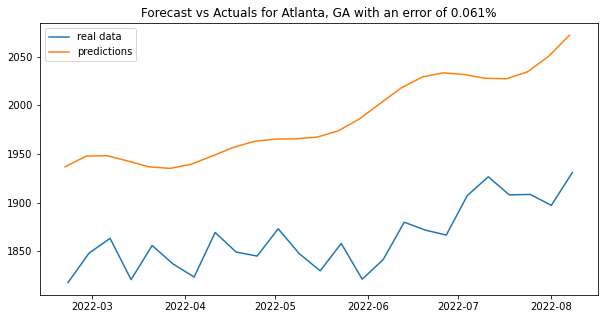

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.586% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 307


  0%|          | 0/114 [00:00<?, ?it/s]

Austin, TX


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.52E-02, min: 3.40E-01


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.41E-02, min: 1.02E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.50E-02
Epoch[307/307]: 100%|██████████| 307/307 [00:08<00:00, 36.87it/s, SmoothL1Loss=0.00397, MAE=49.2, RMSE=82.3, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.586% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 88.67035543174643
mean_absolute_percentage_error on testing set: 0.04758510472460561
r2_score on testing set: -0.9479186781698814
mean_absolute_error on testing set: 88.67035543174643
mean_absolute_percentage_error on testing set: 0.04758510472460561
r2_score on testing set: -0.9479186781698814


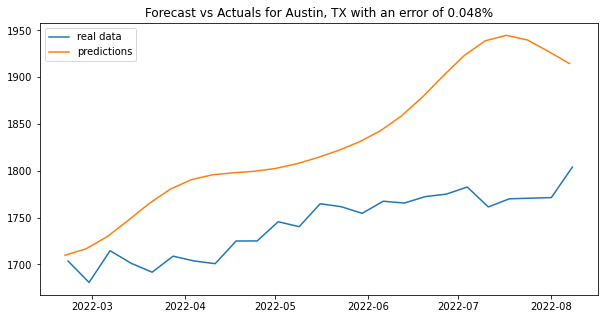

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 302


  0%|          | 0/115 [00:00<?, ?it/s]

Baltimore, MD


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.39E-01, min: 1.00E-01


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.83E-02, min: 1.00E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.53E-01
Epoch[302/302]: 100%|██████████| 302/302 [00:08<00:00, 36.29it/s, SmoothL1Loss=0.00299, MAE=34.8, RMSE=48.8, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 227.3728157762463
mean_absolute_percentage_error on testing set: 0.10283252090368258
r2_score on testing set: -17.37365265223795
mean_absolute_error on testing set: 227.3728157762463
mean_absolute_percentage_error on testing set: 0.10283252090368258
r2_score on testing set: -17.37365265223795


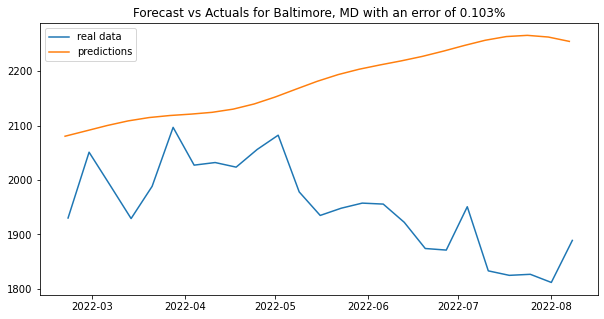

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 91.166% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 310


  0%|          | 0/114 [00:00<?, ?it/s]

Boston, MA


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.76E-02, min: 1.96E-01


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.41E-02, min: 1.96E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.07E-02
Epoch[310/310]: 100%|███████████| 310/310 [00:07<00:00, 39.30it/s, SmoothL1Loss=0.00777, MAE=96.3, RMSE=134, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 91.166% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 136.22069968348512
mean_absolute_percentage_error on testing set: 0.04313724305655468
r2_score on testing set: -3.696972776914179
mean_absolute_error on testing set: 136.22069968348512
mean_absolute_percentage_error on testing set: 0.04313724305655468
r2_score on testing set: -3.696972776914179


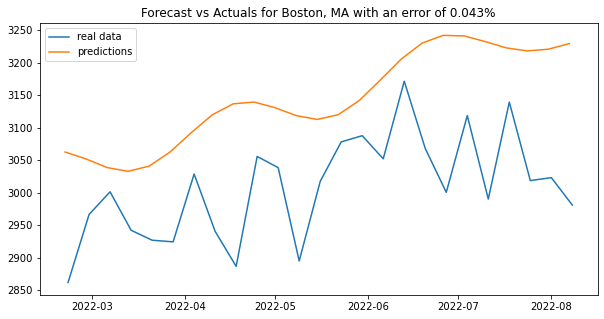

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 93.77% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 300


  0%|          | 0/115 [00:00<?, ?it/s]

Charleston, SC


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.34E-02, min: 1.06E+00


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 1.06E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.41E-02
Epoch[300/300]: 100%|███████████| 300/300 [00:08<00:00, 35.57it/s, SmoothL1Loss=0.0041, MAE=43.8, RMSE=61.2, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 93.77% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 42.2270471946095
mean_absolute_percentage_error on testing set: 0.023374654680609175
r2_score on testing set: 0.29520716371458755
mean_absolute_error on testing set: 42.2270471946095
mean_absolute_percentage_error on testing set: 0.023374654680609175
r2_score on testing set: 0.29520716371458755


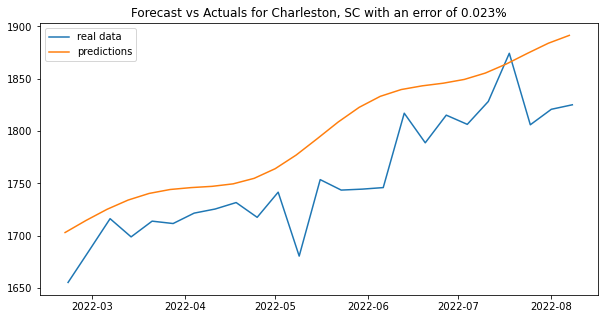

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.735% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 298


  0%|          | 0/115 [00:00<?, ?it/s]

Charlotte, NC


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.73E-01, min: 2.20E+00


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.73E-01, min: 1.53E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.44E-01
Epoch[298/298]: 100%|███████████| 298/298 [00:08<00:00, 35.38it/s, SmoothL1Loss=0.000739, MAE=24.8, RMSE=33, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.735% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 98.04981362944037
mean_absolute_percentage_error on testing set: 0.05136372423594723
r2_score on testing set: -2.324455973036319
mean_absolute_error on testing set: 98.04981362944037
mean_absolute_percentage_error on testing set: 0.05136372423594723
r2_score on testing set: -2.324455973036319


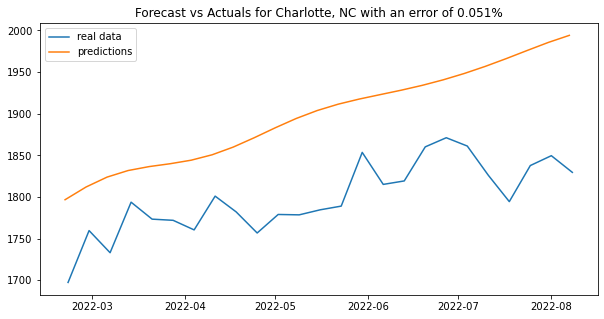

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.287% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 323


  0%|          | 0/113 [00:00<?, ?it/s]

Chicago, IL


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.11E-02, min: 1.28E-01


  0%|          | 0/113 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.07E-02, min: 1.28E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.77E-02
Epoch[323/323]: 100%|████████████| 323/323 [00:07<00:00, 41.68it/s, SmoothL1Loss=0.00312, MAE=61.6, RMSE=82, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.287% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 121.2635448905953
mean_absolute_percentage_error on testing set: 0.049465420745641656
r2_score on testing set: -0.40869253799083594
mean_absolute_error on testing set: 121.2635448905953
mean_absolute_percentage_error on testing set: 0.049465420745641656
r2_score on testing set: -0.40869253799083594


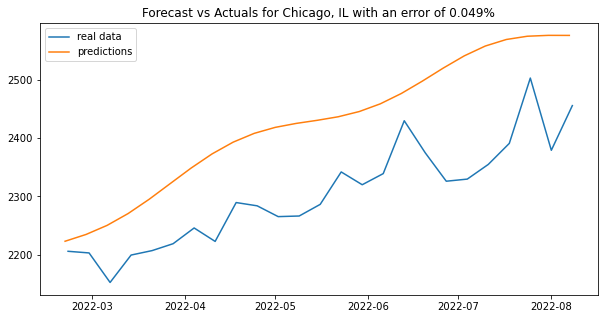

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.43% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 283


  0%|          | 0/116 [00:00<?, ?it/s]

Dallas, TX


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.52E-01, min: 3.75E-01


  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.52E-01, min: 3.75E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.32E-01
Epoch[283/283]: 100%|█████████████| 283/283 [00:08<00:00, 33.92it/s, SmoothL1Loss=0.0028, MAE=23.8, RMSE=33, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.43% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 137.93455993607003
mean_absolute_percentage_error on testing set: 0.07553812373064886
r2_score on testing set: -6.325678807488362
mean_absolute_error on testing set: 137.93455993607003
mean_absolute_percentage_error on testing set: 0.07553812373064886
r2_score on testing set: -6.325678807488362


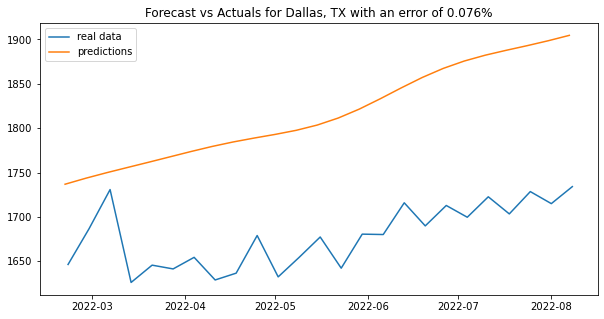

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.765% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 292


  0%|          | 0/115 [00:00<?, ?it/s]

Denver, CO


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.95E-02, min: 2.07E-01


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.95E-02, min: 2.07E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.85E-02
Epoch[292/292]: 100%|████████████| 292/292 [00:08<00:00, 35.22it/s, SmoothL1Loss=0.0109, MAE=52.8, RMSE=100, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.765% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 90.90410050670556
mean_absolute_percentage_error on testing set: 0.04265622414886268
r2_score on testing set: -0.8590923374621835
mean_absolute_error on testing set: 90.90410050670556
mean_absolute_percentage_error on testing set: 0.04265622414886268
r2_score on testing set: -0.8590923374621835


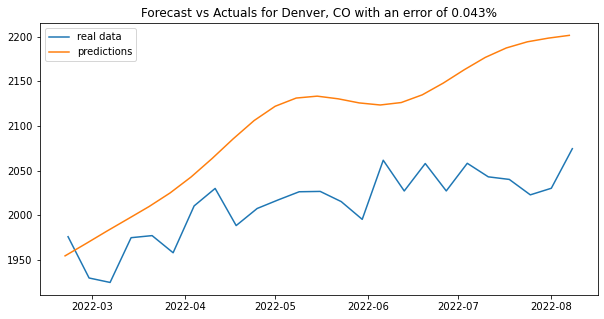

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.916% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 277


  0%|          | 0/116 [00:00<?, ?it/s]

Houston, TX


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.16E-02, min: 1.27E-01


  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.16E-02, min: 1.11E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.44E-02
Epoch[277/277]: 100%|██████████| 277/277 [00:09<00:00, 30.71it/s, SmoothL1Loss=0.00983, MAE=41.5, RMSE=60.1, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.916% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 98.12122525653962
mean_absolute_percentage_error on testing set: 0.05936598820937901
r2_score on testing set: -9.936123435764763
mean_absolute_error on testing set: 98.12122525653962
mean_absolute_percentage_error on testing set: 0.05936598820937901
r2_score on testing set: -9.936123435764763


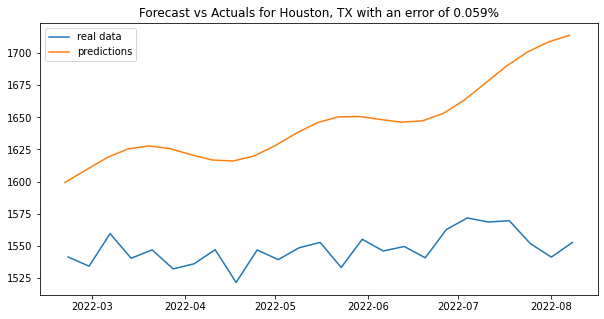

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.281% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 313


Jacksonville, FL


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.50E-01, min: 1.36E-01


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.23E+00, min: 1.36E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.71E-01
Epoch[313/313]: 100%|████████████| 313/313 [00:07<00:00, 39.61it/s, SmoothL1Loss=0.00198, MAE=28, RMSE=36.6, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.281% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 159.97053430049502
mean_absolute_percentage_error on testing set: 0.08445083760346254
r2_score on testing set: -4.4653128914760885
mean_absolute_error on testing set: 159.97053430049502
mean_absolute_percentage_error on testing set: 0.08445083760346254
r2_score on testing set: -4.4653128914760885


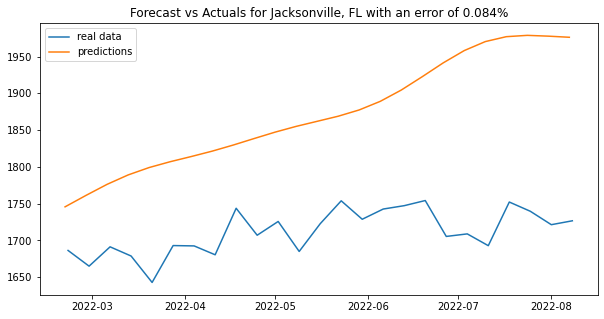

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.322% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 303


  0%|          | 0/114 [00:00<?, ?it/s]

Las Vegas, NV


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.13E-01, min: 2.35E-01


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.36E-01, min: 2.83E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.15E-01
Epoch[303/303]: 100%|███████████| 303/303 [00:07<00:00, 38.66it/s, SmoothL1Loss=0.000547, MAE=21, RMSE=26.3, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.322% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 163.27401672885944
mean_absolute_percentage_error on testing set: 0.0869694520670927
r2_score on testing set: -9.459533997625746
mean_absolute_error on testing set: 163.27401672885944
mean_absolute_percentage_error on testing set: 0.0869694520670927
r2_score on testing set: -9.459533997625746


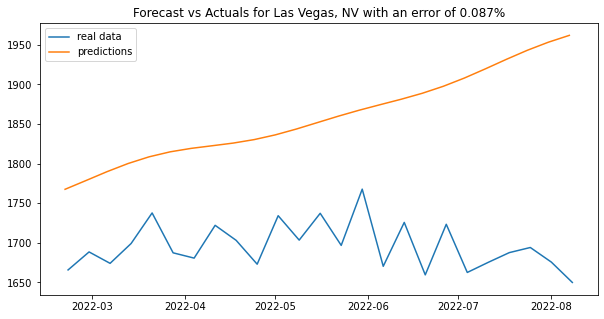

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.45% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 282


  0%|          | 0/116 [00:00<?, ?it/s]

Los Angeles, CA


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.41E-02, min: 1.11E+00


  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.41E-02, min: 1.11E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.19E-02
Epoch[282/282]: 100%|████████████| 282/282 [00:08<00:00, 31.69it/s, SmoothL1Loss=0.00129, MAE=44, RMSE=57.4, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.45% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 234.14225704712058
mean_absolute_percentage_error on testing set: 0.07186005734363834
r2_score on testing set: -10.808714588639406
mean_absolute_error on testing set: 234.14225704712058
mean_absolute_percentage_error on testing set: 0.07186005734363834
r2_score on testing set: -10.808714588639406


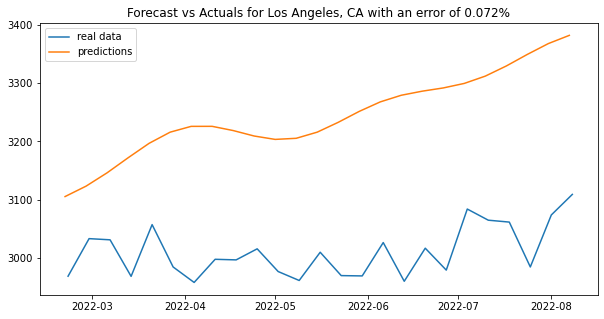

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 96.761% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 330


  0%|          | 0/113 [00:00<?, ?it/s]

Miami, FL


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.06E-01, min: 3.23E-01


  0%|          | 0/113 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.28E-01, min: 1.18E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.11E-01
Epoch[330/330]: 100%|███████████| 330/330 [00:07<00:00, 44.51it/s, SmoothL1Loss=0.0021, MAE=38.6, RMSE=50.9, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 96.761% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 182.78748826284703
mean_absolute_percentage_error on testing set: 0.06348254680334806
r2_score on testing set: -2.4595927765378334
mean_absolute_error on testing set: 182.78748826284703
mean_absolute_percentage_error on testing set: 0.06348254680334806
r2_score on testing set: -2.4595927765378334


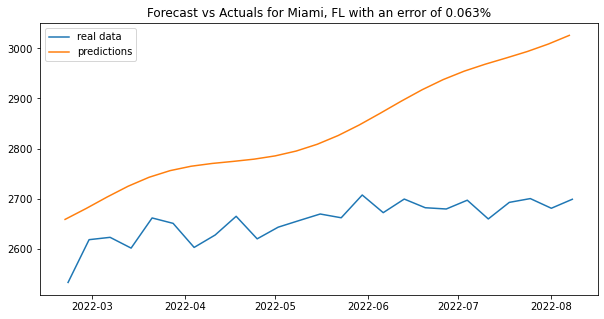

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.086% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 357


  0%|          | 0/112 [00:00<?, ?it/s]

Nashville, TN


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.30E-02, min: 2.54E-01


  0%|          | 0/112 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.26E-02, min: 3.07E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.47E-02
Epoch[357/357]: 100%|██████████| 357/357 [00:07<00:00, 50.21it/s, SmoothL1Loss=0.00639, MAE=44.1, RMSE=59.8, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.086% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 168.69347094899211
mean_absolute_percentage_error on testing set: 0.07827561255143771
r2_score on testing set: -4.821734875092804
mean_absolute_error on testing set: 168.69347094899211
mean_absolute_percentage_error on testing set: 0.07827561255143771
r2_score on testing set: -4.821734875092804


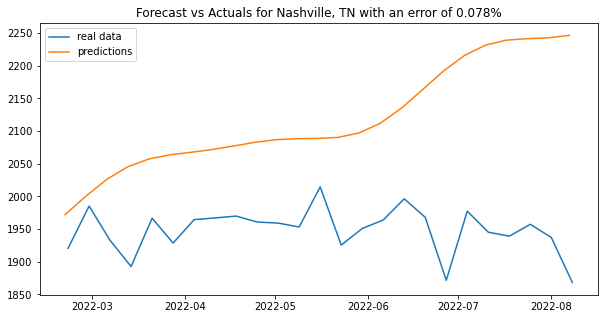

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.872% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 311


  0%|          | 0/114 [00:00<?, ?it/s]

New York, NY


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.96E-01, min: 1.02E+00


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.83E-02, min: 1.02E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.15E-01
Epoch[311/311]: 100%|███████████| 311/311 [00:07<00:00, 40.37it/s, SmoothL1Loss=0.00465, MAE=99.4, RMSE=145, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.872% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 445.097471724814
mean_absolute_percentage_error on testing set: 0.10534142081422523
r2_score on testing set: -3.028165771127491
mean_absolute_error on testing set: 445.097471724814
mean_absolute_percentage_error on testing set: 0.10534142081422523
r2_score on testing set: -3.028165771127491


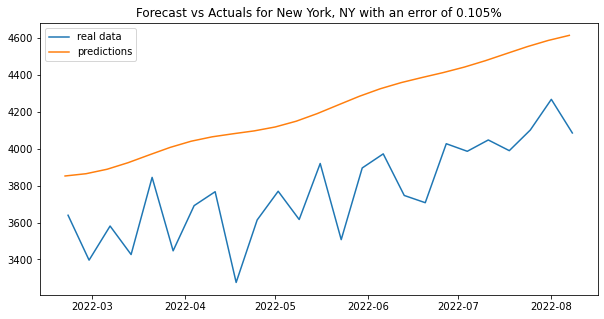

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.872% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 311


  0%|          | 0/114 [00:00<?, ?it/s]

Orlando, FL


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.35E-01, min: 3.40E-01


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.63E-01, min: 1.23E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.57E-01
Epoch[311/311]: 100%|██████████| 311/311 [00:07<00:00, 40.34it/s, SmoothL1Loss=0.00166, MAE=32.6, RMSE=41.2, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.872% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 146.87813321365175
mean_absolute_percentage_error on testing set: 0.06802352202209379
r2_score on testing set: -2.4375371049290835
mean_absolute_error on testing set: 146.87813321365175
mean_absolute_percentage_error on testing set: 0.06802352202209379
r2_score on testing set: -2.4375371049290835


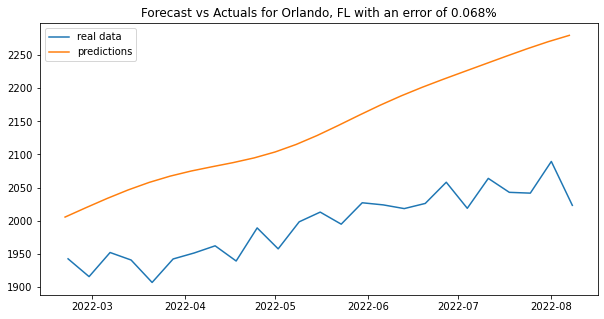

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.732% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 276


  0%|          | 0/116 [00:00<?, ?it/s]

Phoenix, AZ


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.16E-02, min: 1.06E-01


  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.23E-01, min: 1.06E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.68E-01
Epoch[276/276]: 100%|██████████| 276/276 [00:09<00:00, 28.43it/s, SmoothL1Loss=0.00143, MAE=24.9, RMSE=35.6, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.732% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 150.29744786143402
mean_absolute_percentage_error on testing set: 0.0779908477495368
r2_score on testing set: -6.955305860009705
mean_absolute_error on testing set: 150.29744786143402
mean_absolute_percentage_error on testing set: 0.0779908477495368
r2_score on testing set: -6.955305860009705


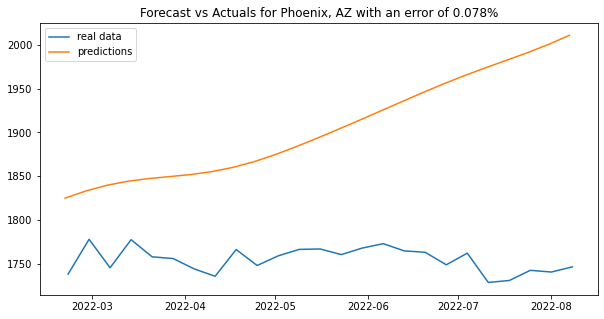

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.271% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 284


  0%|          | 0/116 [00:00<?, ?it/s]

Portland, OR


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.82E-01, min: 4.49E-01


  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.27E-01, min: 5.38E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.32E-01
Epoch[284/284]: 100%|██████████| 284/284 [00:08<00:00, 32.38it/s, SmoothL1Loss=0.00186, MAE=42.4, RMSE=60.4, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.271% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 19.745613174368984
mean_absolute_percentage_error on testing set: 0.01118841311911928
r2_score on testing set: 0.570754932071745
mean_absolute_error on testing set: 19.745613174368984
mean_absolute_percentage_error on testing set: 0.01118841311911928
r2_score on testing set: 0.570754932071745


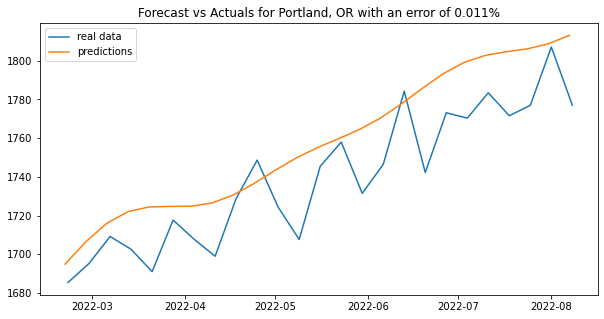

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.173% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 310


  0%|          | 0/114 [00:00<?, ?it/s]

Raleigh, NC


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.13E-01, min: 2.83E-01


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.13E-01, min: 2.83E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.08E-01
Epoch[310/310]: 100%|██████████| 310/310 [00:08<00:00, 35.40it/s, SmoothL1Loss=0.00736, MAE=53.1, RMSE=76.3, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.173% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 65.44210037067782
mean_absolute_percentage_error on testing set: 0.03711379116691262
r2_score on testing set: -0.3897145182660662
mean_absolute_error on testing set: 65.44210037067782
mean_absolute_percentage_error on testing set: 0.03711379116691262
r2_score on testing set: -0.3897145182660662


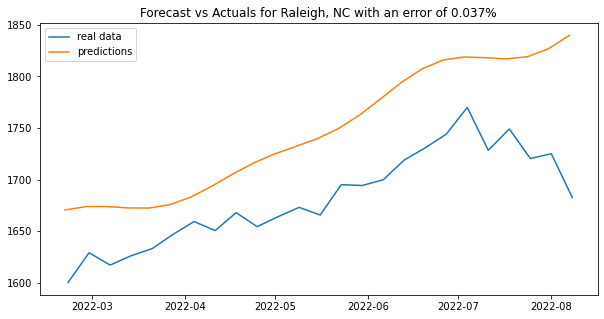

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.12% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 319


  0%|          | 0/114 [00:00<?, ?it/s]

Riverside, CA


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.41E-02, min: 2.35E-01


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.41E-02, min: 1.96E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.60E-02
Epoch[319/319]: 100%|███████████| 319/319 [00:07<00:00, 40.24it/s, SmoothL1Loss=0.00203, MAE=65.5, RMSE=104, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.12% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 105.5105688022343
mean_absolute_percentage_error on testing set: 0.04018616075781498
r2_score on testing set: -1.2277001825312182
mean_absolute_error on testing set: 105.5105688022343
mean_absolute_percentage_error on testing set: 0.04018616075781498
r2_score on testing set: -1.2277001825312182


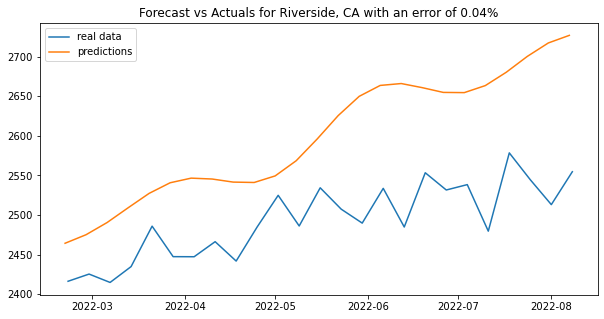

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 96.677% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 290


  0%|          | 0/115 [00:00<?, ?it/s]

San Antonio, TX


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.83E-02, min: 1.00E-01


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.03E-02, min: 1.00E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.80E-02
Epoch[290/290]: 100%|████████████| 290/290 [00:08<00:00, 33.35it/s, SmoothL1Loss=0.00906, MAE=40, RMSE=53.7, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 96.677% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 44.00294182919201
mean_absolute_percentage_error on testing set: 0.03233420246226698
r2_score on testing set: -1.451099236059295
mean_absolute_error on testing set: 44.00294182919201
mean_absolute_percentage_error on testing set: 0.03233420246226698
r2_score on testing set: -1.451099236059295


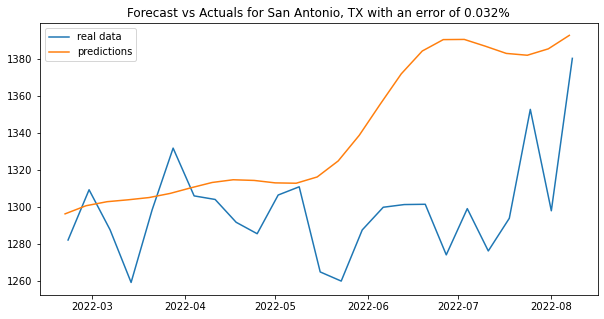

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 96.739% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 314


  0%|          | 0/114 [00:00<?, ?it/s]

San Diego, CA


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.96E-01, min: 1.47E+00


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.63E-01, min: 1.77E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.47E-01
Epoch[314/314]: 100%|██████████| 314/314 [00:08<00:00, 38.19it/s, SmoothL1Loss=0.00124, MAE=42.7, RMSE=55.6, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 96.739% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 129.2290816427539
mean_absolute_percentage_error on testing set: 0.04282884887233859
r2_score on testing set: -2.1967700672359816
mean_absolute_error on testing set: 129.2290816427539
mean_absolute_percentage_error on testing set: 0.04282884887233859
r2_score on testing set: -2.1967700672359816


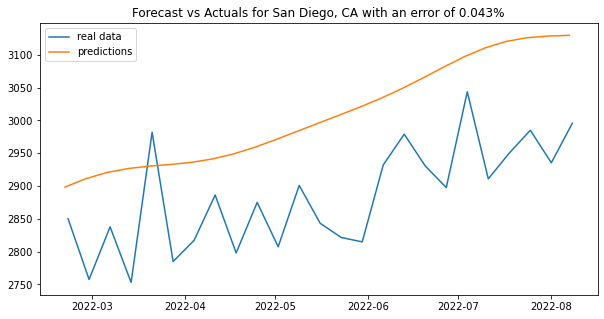

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.154% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 292


  0%|          | 0/115 [00:00<?, ?it/s]

San Francisco, CA


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 2.48E-01


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 2.48E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.00E-01
Epoch[292/292]: 100%|███████████| 292/292 [00:08<00:00, 34.66it/s, SmoothL1Loss=0.00493, MAE=96.9, RMSE=156, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.154% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 140.6286972998482
mean_absolute_percentage_error on testing set: 0.04374704140190765
r2_score on testing set: -3.1600125300456066
mean_absolute_error on testing set: 140.6286972998482
mean_absolute_percentage_error on testing set: 0.04374704140190765
r2_score on testing set: -3.1600125300456066


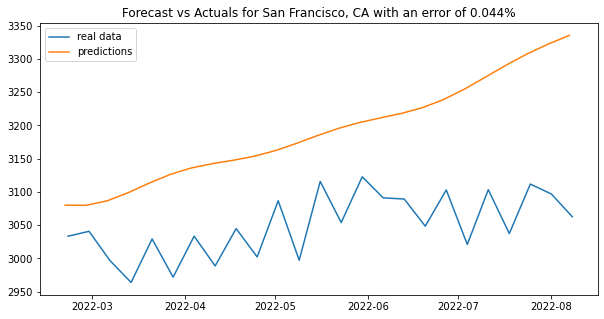

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.31% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 307


  0%|          | 0/114 [00:00<?, ?it/s]

San Jose, CA


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.36E-01, min: 3.40E-01


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.36E-01, min: 3.40E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.23E-01
Epoch[307/307]: 100%|██████████| 307/307 [00:08<00:00, 37.85it/s, SmoothL1Loss=0.00483, MAE=53.1, RMSE=71.5, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.31% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 127.57561261227829
mean_absolute_percentage_error on testing set: 0.03882898272188529
r2_score on testing set: -0.24001232424850016
mean_absolute_error on testing set: 127.57561261227829
mean_absolute_percentage_error on testing set: 0.03882898272188529
r2_score on testing set: -0.24001232424850016


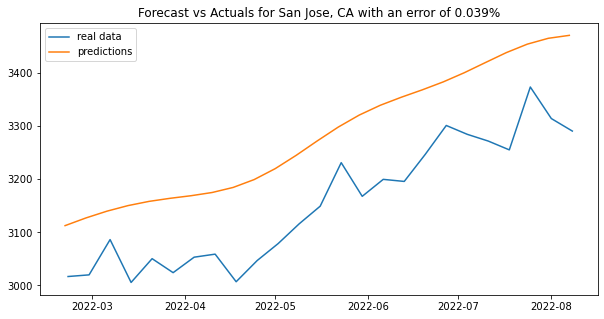

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.282% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 306


  0%|          | 0/114 [00:00<?, ?it/s]

Seattle, WA


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.43E-02, min: 1.13E-01


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.43E-02, min: 1.13E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.65E-02
Epoch[306/306]: 100%|████████████| 306/306 [00:08<00:00, 38.18it/s, SmoothL1Loss=0.00128, MAE=49, RMSE=65.5, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.282% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 229.77686451108406
mean_absolute_percentage_error on testing set: 0.0943456474782605
r2_score on testing set: -5.173840411899194
mean_absolute_error on testing set: 229.77686451108406
mean_absolute_percentage_error on testing set: 0.0943456474782605
r2_score on testing set: -5.173840411899194


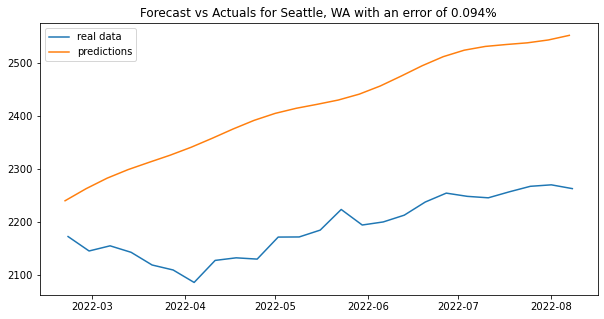

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.518% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 311


  0%|          | 0/114 [00:00<?, ?it/s]

Tampa, FL


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.52E-02, min: 3.40E-01


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.83E-02, min: 7.07E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.99E-02
Epoch[311/311]: 100%|██████████| 311/311 [00:08<00:00, 35.45it/s, SmoothL1Loss=0.00122, MAE=30.6, RMSE=41.4, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.518% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 177.92599859432798
mean_absolute_percentage_error on testing set: 0.07833478331293989
r2_score on testing set: -2.6875851064003844
mean_absolute_error on testing set: 177.92599859432798
mean_absolute_percentage_error on testing set: 0.07833478331293989
r2_score on testing set: -2.6875851064003844


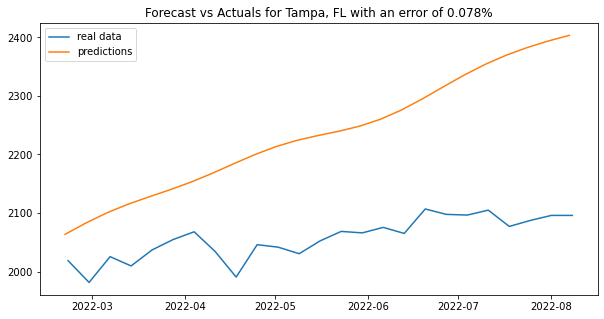

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 302


  0%|          | 0/115 [00:00<?, ?it/s]

Washington, DC


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 2.98E-01


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 2.98E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.00E-01
Epoch[302/302]: 100%|████████████| 302/302 [00:08<00:00, 35.29it/s, SmoothL1Loss=0.00261, MAE=46, RMSE=61.2, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 201.09630435615415
mean_absolute_percentage_error on testing set: 0.08167767428189268
r2_score on testing set: -14.91379317952253
mean_absolute_error on testing set: 201.09630435615415
mean_absolute_percentage_error on testing set: 0.08167767428189268
r2_score on testing set: -14.91379317952253


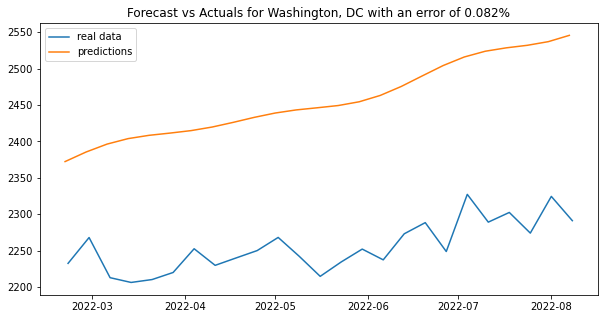

In [29]:
for unique_val, subset in subsets.items():
    if unique_val in msa_data_lst:
    
        ## experimenting with a dataset
        prediction_period = 25
        algorithm_name = 'Neural Prophet Model'

        results = NeuralProphetModel(algorithm_name, prediction_period)
        print(unique_val)

        df_train, df_test = results.transformation(subset, 'WEEK_START', 'NER')        
        
        results.fit_model(df_train)
        predictions = results.predict(df_train)
        results.evaluation(df_test, predictions)
        results.plot(df_test, predictions, unique_val)

In [45]:
predictions['yhat1']

0     1712.217529
1     1718.208008
2     1729.208008
3     1744.072021
4     1760.005493
5     1774.007080
6     1784.229370
7     1790.616699
8     1794.585205
9     1798.049561
10    1802.401367
11    1808.022705
12    1814.552490
13    1821.655273
14    1829.740967
15    1840.084229
16    1854.163574
17    1872.518066
18    1893.786377
19    1914.583496
20    1930.510010
21    1937.978149
22    1936.059082
23    1927.411133
24    1917.694092
Name: yhat1, dtype: float64

**Extracting the data into a df**

In [95]:
msa_data = pd.read_csv('msa_data.csv')
msa_data_lst = list(msa_data['MSA'])

subsets = dict((x, y) for x, y in raot_cta_ner.groupby(['MSA']))

for unique_val, subset in subsets.items():
    subsets[unique_val] = subset.groupby('WEEK_START').mean('NER').reset_index()

In [96]:
column_names = ["Model", "Time", "MSA", "Actuals", "Predictions", 'MAPE score']

df_neural_prophet = pd.DataFrame(columns = column_names)
df_neural_prophet

,Model,Time,MSA,Actuals,Predictions,MAPE score


In [97]:
for unique_val, subset in subsets.items():
    if unique_val in msa_data_lst:
    
    
        column_names = ["Model", "Time", "MSA", "Actuals", "Predictions", 'MAPE score']

        df = pd.DataFrame(columns = column_names)
        ## experimenting with a dataset
        prediction_period = 25
        algorithm_name = 'Neural Prophet Model'

        results = NeuralProphetModel(algorithm_name, prediction_period)
        
        
        df_train, df_test = results.transformation(subset, 'WEEK_START', 'NER')
        
        
        results.fit_model(df_train)
        predictions = results.predict(df_train)
        mape_score = results.evaluation(df_test, predictions)
        #print(predictions['yhat1'])
        df['Actuals'] =  df_test['y']
        df['Time'] =  df_test['ds']
        df['Predictions'] =  list(predictions['yhat1'])
        df['MAPE score'] =  mape_score
        df['Model'] =  algorithm_name
        df['MSA'] =  unique_val
        #print(df)

        #results.evaluation(df_test, predictions)
        df_neural_prophet = df_neural_prophet.append(df, ignore_index=True)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 95.294% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 325


  0%|          | 0/113 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.11E-02, min: 1.28E-01


  0%|          | 0/113 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.11E-02, min: 1.28E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.20E-02
Epoch[325/325]: 100%|████████████| 325/325 [00:08<00:00, 39.43it/s, SmoothL1Loss=0.00368, MAE=63, RMSE=97.7, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 95.294% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.586% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/114 [00:00<?, ?it/s]

mean_absolute_error on testing set: 121.8131588683012
mean_absolute_percentage_error on testing set: 0.06120359183431046
r2_score on testing set: -7.864271969060125


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.41E-02, min: 7.07E-01


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.41E-02, min: 1.47E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.60E-02
Epoch[307/307]: 100%|████████████| 307/307 [00:08<00:00, 34.81it/s, SmoothL1Loss=0.00395, MAE=48.8, RMSE=81, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.586% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.333% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/115 [00:00<?, ?it/s]

mean_absolute_error on testing set: 88.12124410362144
mean_absolute_percentage_error on testing set: 0.047302346629186136
r2_score on testing set: -0.9055222676565915


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.03E-02, min: 1.00E-01


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.36E-02, min: 8.34E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.13E-02
Epoch[302/302]: 100%|██████████| 302/302 [00:08<00:00, 35.49it/s, SmoothL1Loss=0.00311, MAE=35.5, RMSE=48.9, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 91.166% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/114 [00:00<?, ?it/s]

mean_absolute_error on testing set: 226.5173665574963
mean_absolute_percentage_error on testing set: 0.10271363887251159
r2_score on testing set: -21.57867666912134


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.52E-02, min: 2.83E-01


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.52E-02, min: 1.96E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.65E-02
Epoch[310/310]: 100%|███████████| 310/310 [00:08<00:00, 37.76it/s, SmoothL1Loss=0.00778, MAE=96.5, RMSE=135, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 91.166% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 93.77% of the data.
INFO - (NP.df_utils._infer_frequency) 

  0%|          | 0/115 [00:00<?, ?it/s]

mean_absolute_error on testing set: 137.30086569911012
mean_absolute_percentage_error on testing set: 0.04346741044077904
r2_score on testing set: -3.757184659365108


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.95E-02, min: 1.06E+00


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.34E-02, min: 2.48E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.34E-02
Epoch[300/300]: 100%|██████████| 300/300 [00:08<00:00, 33.83it/s, SmoothL1Loss=0.00407, MAE=44.1, RMSE=60.8, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 93.77% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.735% of the data.
INFO - (NP.df_utils._infer_frequency) 

  0%|          | 0/115 [00:00<?, ?it/s]

mean_absolute_error on testing set: 46.294620436797
mean_absolute_percentage_error on testing set: 0.02562428836078997
r2_score on testing set: 0.16101432526531345


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.95E-02, min: 1.73E-01


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.95E-02, min: 1.53E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.85E-02
Epoch[298/298]: 100%|█████████| 298/298 [00:08<00:00, 33.81it/s, SmoothL1Loss=0.000738, MAE=24.8, RMSE=33.9, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.735% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.287% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/113 [00:00<?, ?it/s]

mean_absolute_error on testing set: 98.16224038725287
mean_absolute_percentage_error on testing set: 0.05139153741691063
r2_score on testing set: -2.1816179102657487


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.84E-02, min: 1.85E-01


  0%|          | 0/113 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.35E-02, min: 1.54E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.66E-02
Epoch[323/323]: 100%|██████████| 323/323 [00:08<00:00, 39.29it/s, SmoothL1Loss=0.00309, MAE=61.2, RMSE=81.1, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.287% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.43% of the data.
INFO - (NP.df_utils._infer_frequency) 

  0%|          | 0/116 [00:00<?, ?it/s]

mean_absolute_error on testing set: 118.3352441093453
mean_absolute_percentage_error on testing set: 0.04828558252359289
r2_score on testing set: -0.33974707575314866


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.16E-02, min: 1.27E-01


  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.18E-02, min: 3.13E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.84E-02
Epoch[283/283]: 100%|██████████| 283/283 [00:09<00:00, 29.45it/s, SmoothL1Loss=0.00281, MAE=23.9, RMSE=33.1, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.43% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.765% of the data.
INFO - (NP.df_utils._infer_frequency) 

  0%|          | 0/115 [00:00<?, ?it/s]

mean_absolute_error on testing set: 137.90064880325752
mean_absolute_percentage_error on testing set: 0.07552954222121092
r2_score on testing set: -6.430137771815689


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 2.20E+00


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 1.53E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.00E-01
Epoch[292/292]: 100%|██████████| 292/292 [00:09<00:00, 31.41it/s, SmoothL1Loss=0.00997, MAE=50.8, RMSE=91.3, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.765% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.916% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/116 [00:00<?, ?it/s]

mean_absolute_error on testing set: 88.67513078014306
mean_absolute_percentage_error on testing set: 0.041696131097001016
r2_score on testing set: -0.9274228581894324


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.16E-02, min: 1.27E-01


  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.16E-02, min: 1.27E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.44E-02
Epoch[277/277]: 100%|████████████| 277/277 [00:09<00:00, 28.59it/s, SmoothL1Loss=0.00986, MAE=41.3, RMSE=59, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.916% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.281% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/114 [00:00<?, ?it/s]

mean_absolute_error on testing set: 98.11233365497712
mean_absolute_percentage_error on testing set: 0.05938724126594094
r2_score on testing set: -10.780075707418336


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.43E-02, min: 1.13E-01


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.43E-02, min: 1.02E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.65E-02
Epoch[313/313]: 100%|██████████| 313/313 [00:08<00:00, 36.59it/s, SmoothL1Loss=0.00201, MAE=28.2, RMSE=36.8, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.281% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.322% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/114 [00:00<?, ?it/s]

mean_absolute_error on testing set: 159.67696984737003
mean_absolute_percentage_error on testing set: 0.08434590979532493
r2_score on testing set: -4.599215313561705


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.50E-01, min: 6.52E-02


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.02E+00, min: 7.83E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.43E-01
Epoch[303/303]: 100%|█████████| 303/303 [00:08<00:00, 35.30it/s, SmoothL1Loss=0.000532, MAE=20.8, RMSE=25.7, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.322% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.45% of the data.
INFO - (NP.df_utils._infer_frequency) 

  0%|          | 0/116 [00:00<?, ?it/s]

mean_absolute_error on testing set: 162.89869446323445
mean_absolute_percentage_error on testing set: 0.08679366753917439
r2_score on testing set: -9.524668076751182


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.27E-01, min: 1.11E+00


  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.27E-01, min: 1.11E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.17E-01
Epoch[282/282]: 100%|██████████| 282/282 [00:09<00:00, 30.14it/s, SmoothL1Loss=0.00129, MAE=43.9, RMSE=57.4, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.45% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 96.761% of the data.
INFO - (NP.df_utils._infer_frequency) 

  0%|          | 0/113 [00:00<?, ?it/s]

mean_absolute_error on testing set: 231.5869445471206
mean_absolute_percentage_error on testing set: 0.071147725139143
r2_score on testing set: -11.221750663004618


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.06E-01, min: 2.23E-01


  0%|          | 0/113 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.06E-01, min: 2.23E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.04E-01
Epoch[330/330]: 100%|██████████| 330/330 [00:08<00:00, 40.29it/s, SmoothL1Loss=0.00215, MAE=39.1, RMSE=51.1, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 96.761% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.086% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/112 [00:00<?, ?it/s]

mean_absolute_error on testing set: 182.65943162222203
mean_absolute_percentage_error on testing set: 0.06344421028928261
r2_score on testing set: -2.4648040450901916


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.93E-02, min: 8.30E-02


  0%|          | 0/112 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.74E-02, min: 1.75E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.71E-02
Epoch[357/357]: 100%|██████████| 357/357 [00:08<00:00, 42.78it/s, SmoothL1Loss=0.00644, MAE=44.7, RMSE=59.8, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.086% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.872% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/114 [00:00<?, ?it/s]

mean_absolute_error on testing set: 160.9375627458671
mean_absolute_percentage_error on testing set: 0.07483777115861463
r2_score on testing set: -4.30286844504136


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.40E-01, min: 1.02E+00


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.52E-02, min: 7.07E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.15E-01
Epoch[311/311]: 100%|███████████| 311/311 [00:08<00:00, 36.42it/s, SmoothL1Loss=0.00463, MAE=99.4, RMSE=146, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.872% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.872% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/114 [00:00<?, ?it/s]

mean_absolute_error on testing set: 443.480801802939
mean_absolute_percentage_error on testing set: 0.10499274687002506
r2_score on testing set: -3.0175870337354933


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.43E-02, min: 1.02E+00


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.43E-02, min: 1.13E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.65E-02
Epoch[311/311]: 100%|██████████| 311/311 [00:08<00:00, 37.50it/s, SmoothL1Loss=0.00166, MAE=32.6, RMSE=41.7, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.872% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.732% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/116 [00:00<?, ?it/s]

mean_absolute_error on testing set: 147.28833829177674
mean_absolute_percentage_error on testing set: 0.06819637173810549
r2_score on testing set: -2.4374240053299046


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.87E-02, min: 2.18E-01


  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.41E-02, min: 1.82E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.69E-02
Epoch[276/276]: 100%|████████████| 276/276 [00:09<00:00, 28.97it/s, SmoothL1Loss=0.00144, MAE=25, RMSE=35.9, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.732% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.271% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/116 [00:00<?, ?it/s]

mean_absolute_error on testing set: 149.019811142684
mean_absolute_percentage_error on testing set: 0.07736900537910034
r2_score on testing set: -6.821690601760525


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.06E-01, min: 2.61E-01


  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.06E-01, min: 2.61E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.04E-01
Epoch[284/284]: 100%|██████████| 284/284 [00:09<00:00, 29.26it/s, SmoothL1Loss=0.00192, MAE=44.4, RMSE=61.4, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.271% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.173% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/114 [00:00<?, ?it/s]

mean_absolute_error on testing set: 22.9869791782435
mean_absolute_percentage_error on testing set: 0.01295698175144609
r2_score on testing set: 0.5126859250099352


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.52E-02, min: 3.40E-01


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.52E-02, min: 3.40E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.89E-02
Epoch[310/310]: 100%|█████████████| 310/310 [00:08<00:00, 36.32it/s, SmoothL1Loss=0.0073, MAE=52.8, RMSE=76, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.173% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.12% of the data.
INFO - (NP.df_utils._infer_frequency) 

  0%|          | 0/114 [00:00<?, ?it/s]

mean_absolute_error on testing set: 66.11371169880282
mean_absolute_percentage_error on testing set: 0.03749384247556895
r2_score on testing set: -0.4309583601767124


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.41E-02, min: 2.35E-01


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.41E-02, min: 1.77E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.60E-02
Epoch[319/319]: 100%|███████████| 319/319 [00:08<00:00, 39.13it/s, SmoothL1Loss=0.00206, MAE=65.2, RMSE=104, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.12% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 96.677% of the data.
INFO - (NP.df_utils._infer_frequency) 

  0%|          | 0/115 [00:00<?, ?it/s]

mean_absolute_error on testing set: 104.4272387241093
mean_absolute_percentage_error on testing set: 0.03979348174097671
r2_score on testing set: -1.2138282517467212


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.34E-02, min: 5.13E-01


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.34E-02, min: 4.28E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.86E-02
Epoch[290/290]: 100%|██████████| 290/290 [00:08<00:00, 32.48it/s, SmoothL1Loss=0.00903, MAE=39.8, RMSE=53.5, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 96.677% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 96.739% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/114 [00:00<?, ?it/s]

mean_absolute_error on testing set: 44.07849846981701
mean_absolute_percentage_error on testing set: 0.03237493279277949
r2_score on testing set: -1.4241001202342338


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.35E-01, min: 4.08E-01


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.41E-02, min: 1.96E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.30E-01
Epoch[314/314]: 100%|██████████| 314/314 [00:08<00:00, 36.80it/s, SmoothL1Loss=0.00116, MAE=41.6, RMSE=53.8, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 96.739% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.154% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/115 [00:00<?, ?it/s]

mean_absolute_error on testing set: 130.7951558615039
mean_absolute_percentage_error on testing set: 0.04330369814401684
r2_score on testing set: -2.1206639528286426


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.20E-01, min: 5.13E-01


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.20E-01, min: 3.57E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.13E-01
Epoch[292/292]: 100%|████████████| 292/292 [00:09<00:00, 31.78it/s, SmoothL1Loss=0.0049, MAE=97.3, RMSE=155, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.154% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.31% of the data.
INFO - (NP.df_utils._infer_frequency) 

  0%|          | 0/114 [00:00<?, ?it/s]

mean_absolute_error on testing set: 140.3006699560982
mean_absolute_percentage_error on testing set: 0.04365271547134198
r2_score on testing set: -3.185448908725421


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.13E-01, min: 1.77E+00


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.36E-01, min: 1.77E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.15E-01
Epoch[307/307]: 100%|██████████| 307/307 [00:08<00:00, 35.28it/s, SmoothL1Loss=0.00481, MAE=53.2, RMSE=70.5, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.31% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.282% of the data.
INFO - (NP.df_utils._infer_frequency) 

  0%|          | 0/114 [00:00<?, ?it/s]

mean_absolute_error on testing set: 127.03410870602829
mean_absolute_percentage_error on testing set: 0.038689223289441105
r2_score on testing set: -0.2797602423208454


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.13E-01, min: 2.35E-01


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.41E-02, min: 2.35E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.02E-01
Epoch[306/306]: 100%|██████████| 306/306 [00:09<00:00, 32.06it/s, SmoothL1Loss=0.00126, MAE=48.6, RMSE=64.7, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.282% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.518% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/114 [00:00<?, ?it/s]

mean_absolute_error on testing set: 228.34880787045907
mean_absolute_percentage_error on testing set: 0.09376171124708288
r2_score on testing set: -4.827362840323292


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.83E-02, min: 1.36E-01


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.43E-02, min: 1.13E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.52E-02
Epoch[311/311]: 100%|██████████| 311/311 [00:08<00:00, 35.52it/s, SmoothL1Loss=0.00118, MAE=30.6, RMSE=40.2, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.518% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.0% of the data.
INFO - (NP.df_utils._infer_frequency) -

  0%|          | 0/115 [00:00<?, ?it/s]

mean_absolute_error on testing set: 177.51877203182798
mean_absolute_percentage_error on testing set: 0.07822284993356395
r2_score on testing set: -2.784664965582288


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.20E+00, min: 1.20E-01


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.83E-02, min: 1.20E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.20E-01
Epoch[302/302]: 100%|████████████| 302/302 [00:08<00:00, 34.81it/s, SmoothL1Loss=0.00261, MAE=46, RMSE=61.8, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 200.84828677802915
mean_absolute_percentage_error on testing set: 0.0815861973359804
r2_score on testing set: -14.899237557473137


In [98]:
df_neural_prophet

,Model,Time,MSA,Actuals,Predictions,MAPE score
0,Neural Prophet Model,2022-02-21,"Atlanta, GA",1817.921198,1937.569824,0.061204
1,Neural Prophet Model,2022-02-28,"Atlanta, GA",1848.099796,1948.969482,0.061204
2,Neural Prophet Model,2022-03-07,"Atlanta, GA",1863.197080,1949.600098,0.061204
3,Neural Prophet Model,2022-03-14,"Atlanta, GA",1820.822218,1943.798584,0.061204
4,Neural Prophet Model,2022-03-21,"Atlanta, GA",1855.841432,1937.433838,0.061204
...,...,...,...,...,...,...
695,Neural Prophet Model,2022-07-11,"Washington, DC",2289.162759,2523.750488,0.081586
696,Neural Prophet Model,2022-07-18,"Washington, DC",2302.472282,2528.111328,0.081586
697,Neural Prophet Model,2022-07-25,"Washington, DC",2274.104898,2531.432129,0.081586
698,Neural Prophet Model,2022-08-01,"Washington, DC",2324.496021,2536.506592,0.081586


In [99]:
df_neural_prophet.to_csv("df_neural_prophet_msa_level.csv")